# Unsupervised Learning Trading Strategy
- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlsxwriter
import math
import yfinance as yf
import pandas_ta
import datetime as dt
import warnings
from yahooquery import Ticker

warnings.filterwarnings('ignore')

In [66]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

symbols_string = " ".join(str(element) for element in symbols_list)
tickers = yf.Tickers(symbols_string)

end_date = '2024-01-01'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# tickers = Ticker(symbols_string, asynchronous=True)

# Default period = ytd, interval = 1d

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df


[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-04 A      38.134415   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095467   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956314   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      Volume  
Date                          
2016-01-04 A       3287300.0  
           AAL    12037200.0  
           AAPL  270597600.0  
           ABBV   10308400.0  
           ABT    12227500.0  
...                      ...  
2023-12-29 YUM     1196800.0  
           ZBH      849600.0  
           ZBRA     251300.0  
           ZION    1420600.0  
           ZTS     1007200.0  

[994508 rows x 6 columns]

In [68]:
df.index.names = ['symbol', 'date']
df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
symbol     date                                                               
2016-01-04 A      38.134415   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095467   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956314   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  
symbol     date               
2016-01-04 A       3287300.0  
           AAL    12037200.0  
           AAPL  270597600.0  
           ABBV   10308400.0  
           ABT    12227500.0  
...                      ...  
2023-12-29 YUM     1196800.0  
           ZBH      849600.0  
           ZBRA     251300.0  
           ZION    1420600.0  
           ZTS     1007200.0  

[994508 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [69]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df

adj close       close        high         low        open  \
symbol     date                                                               
2016-01-04 A      38.134415   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095467   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778080   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956314   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol  
symbol     date                                 
2016-01-04 A       3287300.0         -0.001893  
           AAL    12037200.0         -0.000821  
           AAPL  270597600.0         -0.001233  
           ABBV   10308400.0         -0.047666  
           ABT    12227500.0         -0.010932  
...                      ...               ...  
2023-12-29 YUM     1196800.0          0.000030  
           ZBH      849600.0          0.000044  
           ZBRA     251300.0          0.000073  
           ZION    1420600.0          0.000102  
           ZTS     1007200.0          0.000035  

[994508 rows x 7 columns]

<Axes: xlabel='symbol'>

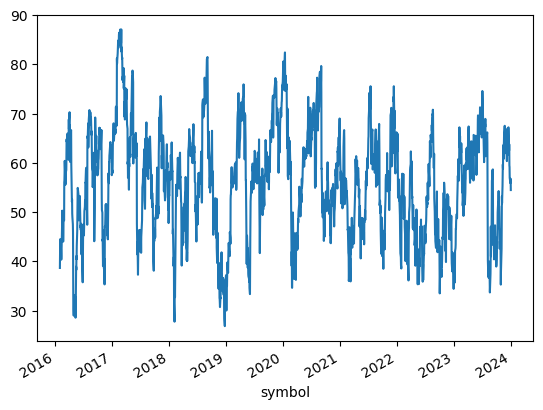

In [70]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length = 20))

df.xs('AAPL', level=1)['rsi'].plot()

In [73]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=x, length = 20))

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [74]:
print(pandas_ta.bbands(close=df['AAPL']['adj close'], length = 20))

KeyError: 'AAPL'